In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
import tensorflow as tf
import sys
import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import cv2

Using TensorFlow backend.


In [2]:
  
class CIFAR10Data():
    def __init__(self):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = cifar10.load_data()
        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        print('CIFAR10 Training data shape:', self.x_train.shape)
        print('CIFAR10 Training label shape', self.y_train.shape)
        print('CIFAR10 Test data shape', self.x_test.shape)
        print('CIFAR10 Test label shape', self.y_test.shape)

    def get_stretch_data(self, subtract_mean=True):
        num_classes = len(self.classes)
        x_train = np.reshape(self.x_train, (self.x_train.shape[0], -1)).astype('float16')
        y_train = keras.utils.to_categorical(self.y_train, num_classes)
        x_test = np.reshape(self.x_test, (self.x_test.shape[0], -1)).astype('float16')
        y_test = keras.utils.to_categorical(self.y_test, num_classes)

        if subtract_mean:
            mean_image = np.mean(x_train, axis=0).astype('uint8')
            x_train -= mean_image
            x_test -= mean_image
        return x_train, y_train, x_test, y_test

    def get_data(self, subtract_mean=True, output_shape=None):
        
        num_classes = len(self.classes)
        x_train = self.x_train
        x_test = self.x_test
        
        x_train = x_train.astype('float16')
        y_train = keras.utils.to_categorical(self.y_train, num_classes)

        x_test = x_test.astype('float16')
        y_test = keras.utils.to_categorical(self.y_test, num_classes)

        if subtract_mean:
            mean_image = np.mean(x_train, axis=0)
            x_train -= mean_image
            x_test -= mean_image
        return x_train, y_train, x_test, y_test


def plot_cifar10(cifar_data, num_sample_per_class):
    num_classes = len(cifar_data.classes)

    plt.figure()
    for y, cls in enumerate(cifar_data.classes):
        cls_indices = np.flatnonzero(cifar_data.y_train == y)
        samples_indices = np.random.choice(cls_indices, num_sample_per_class, replace=False)
        samples = cifar_data.x_train[samples_indices]
        for x, sample in enumerate(samples):
            plt_idx = x * num_classes + y + 1
            plt.subplot(num_sample_per_class, num_classes, plt_idx)
            plt.imshow(sample)
            plt.axis('off')
            if x == 0:
                plt.title(cls)
    plt.show()

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
import tensorflow as tf 
from keras import backend as k
import os
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
k.tensorflow_backend.set_session(tf.Session(config=config))

%load_ext autoreload
%autoreload 2

In [5]:
cifar10_data = CIFAR10Data()
x_train, y_train, x_test, y_test = cifar10_data.get_data(subtract_mean=True)

num_train = int(x_train.shape[0] * 0.8)
num_val = x_train.shape[0] - num_train
mask = list(range(num_train, num_train+num_val))
x_val = x_train[mask]
y_val = y_train[mask]

mask = list(range(num_train))
x_train = x_train[mask]
y_train = y_train[mask]
print(x_train.shape)



170500096/170498071 [==============================] - 48s 0us/step
CIFAR10 Training data shape: (50000, 32, 32, 3)
CIFAR10 Training label shape (50000, 1)
CIFAR10 Test data shape (10000, 32, 32, 3)
CIFAR10 Test label shape (10000, 1)
(40000, 32, 32, 3)


In [6]:
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Input
from keras.layers import AveragePooling2D
from keras import regularizers
from keras.layers import concatenate


def conv2d_bn_relu(x, filters, kernel_size, name, weight_decay=.0, strides=(1, 1), use_bn=True):
    conv_name = name + "-conv"
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               use_bias=False,
               kernel_regularizer=regularizers.l2(weight_decay),
               name=conv_name)(x)
    if use_bn:
        bn_name = name + "-bn"
        x = BatchNormalization(scale=False, axis=3, name=bn_name)(x)
    relu_name = name + "-relu"
    x = Activation('relu', name=relu_name)(x)
    return x


def inception_block_v1(x, filters_num_array, name, weight_decay=.0, use_bn=True):
    (br0_filters, br1_filters, br2_filters, br3_filters) = filters_num_array

    br0 = conv2d_bn_relu(x,
                         filters=br0_filters, kernel_size=(1, 1), weight_decay=weight_decay,
                         name=name + '-br0-1x1', use_bn=use_bn)

    br1 = conv2d_bn_relu(x,
                         filters=br1_filters[0], kernel_size=(1, 1), weight_decay=weight_decay,
                         name=name + '-br1-1x1', use_bn=use_bn)
    br1 = conv2d_bn_relu(br1,
                         filters=br1_filters[1], kernel_size=(3, 3), weight_decay=weight_decay,
                         name=name + '-br1-3x3', use_bn=use_bn)

    br2 = conv2d_bn_relu(x,
                         filters=br2_filters[0], kernel_size=(1, 1), weight_decay=weight_decay,
                         name=name + '-br2-1x1', use_bn=use_bn)
    br2 = conv2d_bn_relu(br2, filters=br2_filters[1], kernel_size=(5, 5), name=name + '-br2-5x5', use_bn=use_bn)

    br3 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same', name=name + '-br3-pool')(x)
    br3 = conv2d_bn_relu(br3, filters=br3_filters, kernel_size=(1, 1), weight_decay=weight_decay, name=name + '-br3-1x1')

    x = concatenate([br0, br1, br2, br3], axis=3, name=name)
    return x


def aux_classifier_v1(x, num_classes, name):
    aux_classifier = AveragePooling2D(pool_size=(5, 5), strides=(3, 3), name=name + '-averagePool')(x)
    aux_classifier = conv2d_bn_relu(aux_classifier, filters=128, kernel_size=(1, 1), name=name+'-1x1conv')
    aux_classifier = Flatten(name=name + '-flatten')(aux_classifier)
    aux_classifier = Dense(1024)(aux_classifier)
    aux_classifier = Dropout(0.3, name=name + '-dropout')(aux_classifier)
    aux_classifier = Dense(num_classes, activation='softmax', name=name + '-predictions')(aux_classifier)
    return aux_classifier


def InceptionV1(input_shape, classes, weight_decay=.0, use_bn=True):
    input = Input(shape=input_shape)
    x = input
    x = conv2d_bn_relu(x,
                       filters=64, kernel_size=(7, 7), name='1a',
                       weight_decay=weight_decay, strides=(2, 2), use_bn=use_bn)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='1-pool')(x)
    x = conv2d_bn_relu(x,
                       filters=64, kernel_size=(1, 1), weight_decay=weight_decay,
                       name='2a', use_bn=use_bn)
    x = conv2d_bn_relu(x, filters=192, kernel_size=(3, 3), weight_decay=weight_decay,
                       name='2b', use_bn=use_bn)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='2-pool')(x)
    x = inception_block_v1(x, (64, (96, 128), (16, 32), 32),
                           weight_decay=weight_decay,
                           name='inception3a', use_bn=use_bn)
    x = inception_block_v1(x, (128, (128, 192), (32, 96), 64),
                           weight_decay=weight_decay,
                           name='inception3b', use_bn=use_bn)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='3pool')(x)

    x = inception_block_v1(x, (192, (96, 208), (16, 48), 64),
                           weight_decay=weight_decay,
                           name='inception4a', use_bn=use_bn)
    x = inception_block_v1(x, (160, (112, 224), (24, 64), 64),
                           weight_decay=weight_decay,
                           name='inception4b', use_bn=True)
    x = inception_block_v1(x, (128, (128, 256), (24, 64), 64),
                           weight_decay=weight_decay,
                           name='inception4c', use_bn=use_bn)
    x = inception_block_v1(x, (112, (144, 288), (32, 64), 64),
                           weight_decay=weight_decay,
                           name='inception4d', use_bn=use_bn)
    x = inception_block_v1(x, (256, (160, 320), (32, 128), 128),
                           weight_decay=weight_decay,
                           name='inception4e', use_bn=use_bn)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='4pool')(x)

    x = inception_block_v1(x, (256, (160, 320), (32, 128), 128),
                           weight_decay=weight_decay,
                           name='inception5a', use_bn=use_bn)
    x = inception_block_v1(x, (384, (192, 384), (48, 128), 128),
                           weight_decay=weight_decay,
                           name='inception5b', use_bn=use_bn)
    x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid', name='avg7x7')(x)
    x = Dropout(0.4)(x)
    x = Flatten(name='flatten')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    model = Model(input, x, name='inception_v1')
    return model


def InceptionV1ForCIFAR10(input_shape, classes, weight_decay=.0, use_bn=True):
    input = Input(shape=input_shape)
    x = input
    x = conv2d_bn_relu(x,filters=64, kernel_size=(1, 1), weight_decay=weight_decay,
                       name='2a', use_bn=use_bn)
    x = conv2d_bn_relu(x, filters=192, kernel_size=(3, 3), weight_decay=weight_decay,
                       name='2b', use_bn=use_bn)
    x = inception_block_v1(x, (64, (96, 128), (16, 32), 32),
                           weight_decay=weight_decay,
                           name='inception3a', use_bn=use_bn)
    x = inception_block_v1(x, (128, (128, 192), (32, 96), 64),
                           weight_decay=weight_decay,
                           name='inception3b', use_bn=use_bn)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='3pool')(x)

    
    x = inception_block_v1(x, (192, (96, 208), (16, 48), 64),
                           weight_decay=weight_decay,
                           name='inception4a', use_bn=use_bn)
    
    x = inception_block_v1(x, (160, (112, 224), (24, 64), 64),
                           weight_decay=weight_decay,
                           name='inception4b', use_bn=True)
    
    x = inception_block_v1(x, (128, (128, 256), (24, 64), 64),
                           weight_decay=weight_decay,
                           name='inception4c', use_bn=use_bn)
    
    x = inception_block_v1(x, (112, (144, 288), (32, 64), 64),
                           weight_decay=weight_decay,
                           name='inception4d', use_bn=use_bn)
    
    x = inception_block_v1(x, (256, (160, 320), (32, 128), 128),
                           weight_decay=weight_decay,
                           name='inception4e', use_bn=use_bn)
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='4pool')(x)

    
    x = inception_block_v1(x, (256, (160, 320), (32, 128), 128),
                           weight_decay=weight_decay,
                           name='inception5a', use_bn=use_bn)
    
    x = inception_block_v1(x, (384, (192, 384), (48, 128), 128),
                           weight_decay=weight_decay,
                           name='inception5b', use_bn=use_bn)

    
    x = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), padding='valid', name='avg8x8')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    model = Model(input, x, name='inception_v1')
    return model
from keras import losses

weight_decay = 5e-4
lr = 1e-1
num_classes = 10
inceptionV1 = InceptionV1ForCIFAR10(input_shape=(32, 32, 3), classes=num_classes, weight_decay=weight_decay)
opt = keras.optimizers.SGD(lr=lr, momentum=0.9, nesterov=False)
inceptionV1.compile(optimizer=opt,
                    loss=losses.categorical_crossentropy,
                    metrics=['accuracy'])
inceptionV1.summary()





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
2a-conv (Conv2D)                (None, 32, 32, 64)   192         input_1[0][0]                    
__________________________________________________________________________________________________
2a-bn (BatchNormalization)      (None, 32, 32, 64)   192         2a-conv[0][0]                    
__________________________________________________________________________________________________
2a-relu (Activation)            (None, 32, 32, 64)   0           2a-bn[0][0]                      
__________________________________________________________________________________________________
2b-conv (C

In [7]:
%%time
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
data_augmentation = True


def lr_scheduler(epoch):
    return lr * (0.1 ** (epoch // 30))

reduce_lr = LearningRateScheduler(lr_scheduler)


batch_size = 128
epochs = 30

if data_augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False, 
        zca_whitening=False,  
        rotation_range=15,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True, 
        vertical_flip=False,
    ) 
    print('train with data augmentation')
    history = inceptionV1.fit_generator(generator=datagen.flow(x_train, y_train, batch_size=batch_size),
                                        epochs=epochs,
                                        steps_per_epoch=313,
                                        callbacks=[reduce_lr],
                                        validation_data=(x_val, y_val)
                                        )
else:
    print('train without data augmentation')
    history = inceptionV1.fit(x_train, y_train, 
                      batch_size=batch_size, epochs=epochs, 
                      callbacks=[reduce_lr],
                      validation_data=(x_val, y_val)
                      )

train with data augmentation
Epoch 1/30
313/313 [==============================] - 343s 1s/step - loss: 4.8474 - acc: 0.4005 - val_loss: 4.6373 - val_acc: 0.3049
Epoch 2/30
313/313 [==============================] - 323s 1s/step - loss: 2.9846 - acc: 0.5702 - val_loss: 2.8010 - val_acc: 0.4906
Epoch 3/30
313/313 [==============================] - 322s 1s/step - loss: 2.0531 - acc: 0.6566 - val_loss: 2.0668 - val_acc: 0.5942
Epoch 4/30
313/313 [==============================] - 323s 1s/step - loss: 1.5250 - acc: 0.7132 - val_loss: 2.9069 - val_acc: 0.3743
Epoch 5/30
313/313 [==============================] - 323s 1s/step - loss: 1.2537 - acc: 0.7454 - val_loss: 2.1113 - val_acc: 0.4941
Epoch 6/30
313/313 [==============================] - 323s 1s/step - loss: 1.0969 - acc: 0.7676 - val_loss: 1.2063 - val_acc: 0.7244
Epoch 7/30
313/313 [==============================] - 322s 1s/step - loss: 1.0039 - acc: 0.7815 - val_loss: 1.1765 - val_acc: 0.7163
Epoch 8/30
313/313 [====================

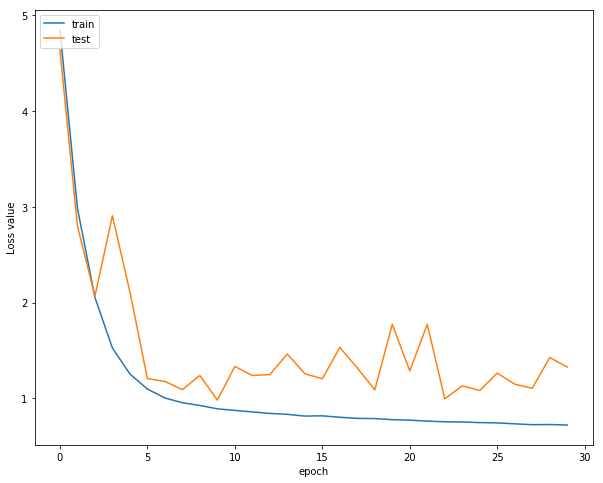

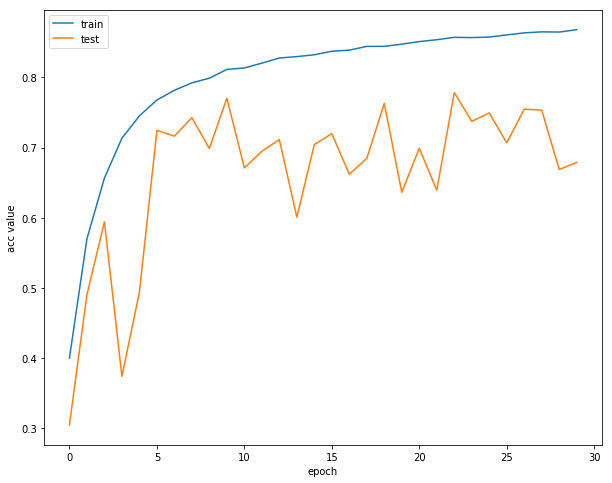

In [8]:
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('Loss value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('acc value')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
loss_train, acc_train = inceptionV1.evaluate(x_train, y_train)
print('evaluate loss:%f Train_acc:%f' % (loss_train, acc_train))
loss_test, acc_test = inceptionV1.evaluate(x_test, y_test)
print('evaluate loss:%f Test_acc:%f' % (loss_test, acc_test))

40000/40000 [==============================] - 113s 3ms/step
evaluate loss:1.257347 Train_acc:0.696450
10000/10000 [==============================] - 28s 3ms/step
evaluate loss:1.337014 Test_acc:0.675700
